In [1]:
import os
from glob import glob
import random
import time
import tensorflow as tf
import datetime
from PIL import Image
import PIL
import random
import numpy as np
from matplotlib.pyplot import imshow
import pandas as pd
from IPython.display import FileLink
import  matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
%matplotlib inline
from IPython.display import display, Image
import matplotlib.image as mpimg
import cv2
import time
import glob
import os
from tqdm import tqdm

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_files
from tensorflow.python.keras.utils import np_utils
from sklearn.utils import shuffle
from sklearn.metrics import log_loss

from tensorflow import keras
import tensorflow.python.keras.backend as K
from tensorflow.python.keras import callbacks
from tensorflow.python.keras import Sequential
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.python.keras.applications.vgg16 import VGG16

In [3]:
dataset = pd.read_csv('input_training/driver_imgs_list.csv')
dataset.head(5)

,subject,classname,img
0,p002,c0,img_44733.jpg
1,p002,c0,img_72999.jpg
2,p002,c0,img_25094.jpg
3,p002,c0,img_69092.jpg
4,p002,c0,img_92629.jpg


In [4]:
by_drivers=dataset.groupby('subject')
unique_drivers = by_drivers.groups.keys()
print(unique_drivers)

dict_keys(['p002', 'p012', 'p014', 'p015', 'p016', 'p021', 'p022', 'p024', 'p026', 'p035', 'p039', 'p041', 'p042', 'p045', 'p047', 'p049', 'p050', 'p051', 'p052', 'p056', 'p061', 'p064', 'p066', 'p072', 'p075', 'p081'])


In [5]:
NUMBER_CLASSES = 10

In [6]:
def get_cv2_image(path, img_rows, img_cols, color_type=3):
    if color_type == 1:
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    elif color_type == 3:
        img = cv2.imread(path, cv2.IMREAD_COLOR)
    img = cv2.resize(img, (img_rows, img_cols)) 
    return img

In [7]:
def load_train(img_rows, img_cols, color_type=3):
    start_time = time.time()
    train_images = [] 
    train_labels = []
    for classed in tqdm(range(NUMBER_CLASSES)):
        print('Loading directory c{}'.format(classed))
        files = glob.glob(os.path.join('input_training', 'train', 'c' + str(classed), '*.jpg'))
        for file in files:
            img = get_cv2_image(file, img_rows, img_cols, color_type)
            train_images.append(img)
            train_labels.append(classed)
    print("Data Loaded in {} second".format(time.time() - start_time))
    return train_images, train_labels

In [8]:
def read_and_normalize_train_data(img_rows, img_cols, color_type):
    X, labels = load_train(img_rows, img_cols, color_type)
    y = np_utils.to_categorical(labels, 10)
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    x_train = np.array(x_train, dtype=np.uint8).reshape(-1,img_rows,img_cols,color_type)
    x_test = np.array(x_test, dtype=np.uint8).reshape(-1,img_rows,img_cols,color_type)
    
    return x_train, x_test, y_train, y_test

In [9]:
# Validation
def load_test(size=200000, img_rows=64, img_cols=64, color_type=3):
    path = os.path.join('input_training', 'test', '*.jpg')
    files = sorted(glob.glob(path))
    X_test, X_test_id = [], []
    total = 0
    files_size = len(files)
    for file in tqdm(files):
        if total >= size or total >= files_size:
            break
        file_base = os.path.basename(file)
        img = get_cv2_image(file, img_rows, img_cols, color_type)
        X_test.append(img)
        X_test_id.append(file_base)
        total += 1
    return X_test, X_test_id

In [10]:
def read_and_normalize_sampled_test_data(size, img_rows, img_cols, color_type=3):
    test_data, test_ids = load_test(size, img_rows, img_cols, color_type)
    
    test_data = np.array(test_data, dtype=np.uint8)
    test_data = test_data.reshape(-1,img_rows,img_cols,color_type)
    
    return test_data, test_ids

In [11]:
img_rows = 64
img_cols = 64
color_type = 1

In [12]:
x_train, x_test, y_train, y_test = read_and_normalize_train_data(img_rows, img_cols, color_type)
print('Train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Loading directory c0


 10%|████████▎                                                                          | 1/10 [00:06<01:00,  6.72s/it]

Loading directory c1


 20%|████████████████▌                                                                  | 2/10 [00:12<00:52,  6.56s/it]

Loading directory c2


 30%|████████████████████████▉                                                          | 3/10 [00:19<00:44,  6.42s/it]

Loading directory c3


 40%|█████████████████████████████████▏                                                 | 4/10 [00:25<00:38,  6.36s/it]

Loading directory c4


 50%|█████████████████████████████████████████▌                                         | 5/10 [00:31<00:30,  6.20s/it]

Loading directory c5


 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:37<00:24,  6.21s/it]

Loading directory c6


 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:43<00:18,  6.19s/it]

Loading directory c7


 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:48<00:11,  5.99s/it]

Loading directory c8


 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:54<00:05,  5.74s/it]

Loading directory c9


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:59<00:00,  5.98s/it]


Data Loaded in 59.75245022773743 second
Train shape: (17939, 64, 64, 1)
17939 train samples


In [13]:
nb_test_samples = 200
test_files, test_targets = read_and_normalize_sampled_test_data(nb_test_samples, img_rows, img_cols, color_type)
print('Test shape:', test_files.shape)
print(test_files.shape[0], 'Test samples')

  0%|▏                                                                            | 200/79726 [00:00<03:33, 371.73it/s]


Test shape: (200, 64, 64, 1)
200 Test samples


In [14]:
names = [item[17:19] for item in sorted(glob.glob("input/train/*/"))]
names = ['c0','c1','c2','c3','c4','c5','c6','c7','c8','c9']
test_files_size = len(np.array(glob.glob(os.path.join('input_training', 'test', '*.jpg'))))
x_train_size = len(x_train)
categories_size = len(names)
x_test_size = len(x_test)
print('There are %s total images.\n' % (test_files_size + x_train_size + x_test_size))
print('There are %d training images.' % x_train_size)
print('There are %d total training categories.' % categories_size)
print('There are %d validation images.' % x_test_size)
print('There are %d test images.'% test_files_size)

There are 102150 total images.

There are 17939 training images.
There are 10 total training categories.
There are 4485 validation images.
There are 79726 test images.


In [15]:
activity_map = {'c0': 'Safe driving', 
                'c1': 'Right - Texting', 
                'c2': 'Right - Talking on the phone', 
                'c3': 'Left - Texting', 
                'c4': 'Left - Talking on the phone', 
                'c5': 'Operating the radio', 
                'c6': 'Drinking', 
                'c7': 'Reaching behind', 
                'c8': 'Hair and makeup', 
                'c9': 'Talking to passenger'}

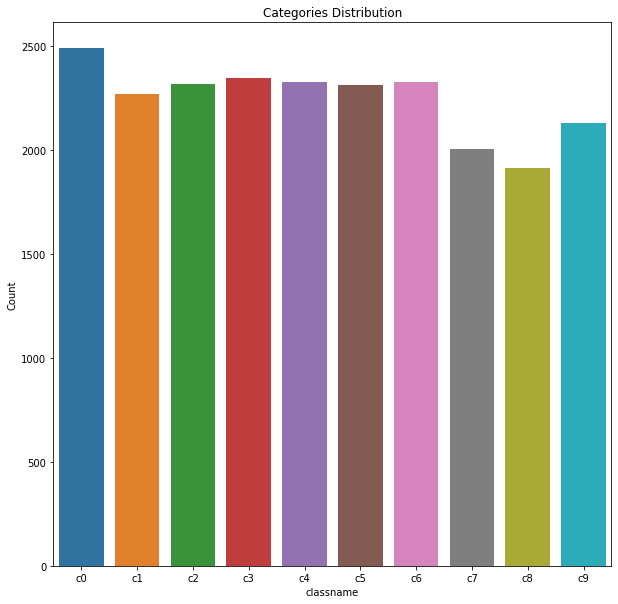

In [16]:
# Plot figure size
plt.figure(figsize = (10,10))
# Count the number of images per category
sns.countplot(x = 'classname', data = dataset)
# Change the Axis names
plt.ylabel('Count')
plt.title('Categories Distribution')
# Show plot
plt.savefig('distribution.png')
plt.show()

In [17]:
batch_size = 40
nb_epoch = 10

In [18]:
!rd -f saved_models/weights_best_vanilla.hdf5

Invalid switch - "weights_best_vanilla.hdf5".


In [19]:
models_dir = "saved_models"
if not os.path.exists(models_dir):
    os.makedirs(models_dir)
    
checkpointer = ModelCheckpoint(filepath='saved_models/weights_best_vanilla.hdf5', 
                               monitor='val_loss', mode='min',
                               verbose=1, save_best_only=True)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
callbacks = [checkpointer, es]

In [20]:
def create_model_v1():
    model = Sequential()

    model.add(Conv2D(filters = 64, kernel_size = 3, padding='same', activation = 'relu', input_shape=(img_rows, img_cols, color_type)))
    model.add(MaxPooling2D(pool_size = 2))

    model.add(Conv2D(filters = 128, padding='same', kernel_size = 3, activation = 'relu'))
    model.add(MaxPooling2D(pool_size = 2))

    model.add(Conv2D(filters = 256, padding='same', kernel_size = 3, activation = 'relu'))
    model.add(MaxPooling2D(pool_size = 2))

    model.add(Conv2D(filters = 512, padding='same', kernel_size = 3, activation = 'relu'))
    model.add(MaxPooling2D(pool_size = 2))

    model.add(Dropout(0.5))

    model.add(Flatten())

    model.add(Dense(500, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation = 'softmax'))
    
    return model

In [21]:
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [22]:
model_v1 = create_model_v1()

model_v1.summary()

model_v1.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 256)       295168    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 256)         0         
____

In [23]:
history_v1 = model_v1.fit(x_train, y_train, 
          validation_data=(x_test, y_test),callbacks=callbacks,
          epochs=nb_epoch, batch_size=batch_size, verbose=1)

Train on 17939 samples, validate on 4485 samples
Epoch 1/10
17920/17939 [============================>.] - ETA: 20:29 - loss: 26.0423 - acc: 0.075 - ETA: 10:34 - loss: 377.1993 - acc: 0.10 - ETA: 5:25 - loss: 195.4855 - acc: 0.1063 - ETA: 3:42 - loss: 131.1780 - acc: 0.104 - ETA: 2:50 - loss: 98.9871 - acc: 0.112 - ETA: 2:19 - loss: 79.6691 - acc: 0.11 - ETA: 2:08 - loss: 72.6393 - acc: 0.11 - ETA: 1:50 - loss: 61.8264 - acc: 0.11 - ETA: 1:37 - loss: 53.8979 - acc: 0.10 - ETA: 1:28 - loss: 47.8357 - acc: 0.10 - ETA: 1:20 - loss: 43.0483 - acc: 0.10 - ETA: 1:14 - loss: 39.1657 - acc: 0.10 - ETA: 1:08 - loss: 35.9644 - acc: 0.10 - ETA: 1:04 - loss: 33.2713 - acc: 0.10 - ETA: 1:00 - loss: 30.9788 - acc: 0.10 - ETA: 57s - loss: 28.9981 - acc: 0.1112 - ETA: 54s - loss: 27.2718 - acc: 0.116 - ETA: 52s - loss: 25.7628 - acc: 0.115 - ETA: 49s - loss: 24.4269 - acc: 0.112 - ETA: 47s - loss: 23.2316 - acc: 0.114 - ETA: 46s - loss: 22.1587 - acc: 0.116 - ETA: 44s - loss: 21.1875 - acc: 0.125 - ET

In [24]:
model_v1.load_weights('saved_models/weights_best_vanilla.hdf5')

In [25]:
def plot_train_history(history):
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

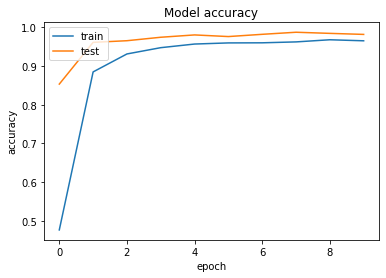

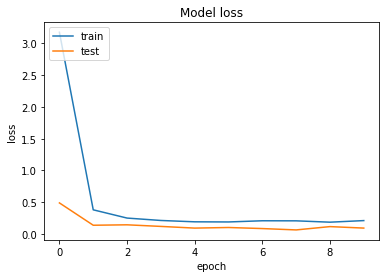

In [26]:
plot_train_history(history_v1)

In [27]:
def plot_test_class(model, test_files, image_number, color_type=1):
    img_brute = test_files[image_number]
    img_brute = cv2.resize(img_brute,(img_rows,img_cols))
    plt.imshow(img_brute, cmap='gray')

    new_img = img_brute.reshape(-1,img_rows,img_cols,color_type)
    plt.show()
    y_prediction = model.predict(new_img, batch_size=batch_size, verbose=1)
    return y_prediction

In [28]:
score = model_v1.evaluate(x_test, y_test, batch_size=32)

4485/4485 [==============================] - ETA: 17s - loss: 6.4744e-05 - acc: 1.00 - ETA: 4s - loss: 0.0310 - acc: 0.9896     - ETA: 2s - loss: 0.1363 - acc: 0.985 - ETA: 2s - loss: 0.1160 - acc: 0.988 - ETA: 2s - loss: 0.0975 - acc: 0.987 - ETA: 1s - loss: 0.0842 - acc: 0.988 - ETA: 1s - loss: 0.0722 - acc: 0.990 - ETA: 1s - loss: 0.0775 - acc: 0.990 - ETA: 1s - loss: 0.0774 - acc: 0.989 - ETA: 1s - loss: 0.0710 - acc: 0.990 - ETA: 1s - loss: 0.0682 - acc: 0.989 - ETA: 1s - loss: 0.0685 - acc: 0.988 - ETA: 1s - loss: 0.0664 - acc: 0.988 - ETA: 1s - loss: 0.0668 - acc: 0.988 - ETA: 0s - loss: 0.0625 - acc: 0.989 - ETA: 0s - loss: 0.0589 - acc: 0.989 - ETA: 0s - loss: 0.0612 - acc: 0.988 - ETA: 0s - loss: 0.0596 - acc: 0.988 - ETA: 0s - loss: 0.0622 - acc: 0.987 - ETA: 0s - loss: 0.0617 - acc: 0.987 - ETA: 0s - loss: 0.0592 - acc: 0.987 - ETA: 0s - loss: 0.0581 - acc: 0.987 - ETA: 0s - loss: 0.0635 - acc: 0.987 - ETA: 0s - loss: 0.0610 - acc: 0.988 - ETA: 0s - loss: 0.0603 - acc: 0.98

In [29]:
print('Loss     = ' ,score[0])
print('Accuracy = ' ,score[1])

Loss     =  0.06506771905390663
Accuracy =  0.986845


# Trying out manual input

In [ ]:
path = 'input/imgs/img_10.jpg'
manual_pics = glob.glob(path)
manual_imgs = []
manual_displays = []
for file in manual_pics:    
    #for displaying the picture
    manual_display = get_cv2_image(file,640,480)
    manual_displays.append(manual_display)
    
    manual = get_cv2_image(file, img_rows=64, img_cols=64, color_type=1)
    manual_imgs.append(manual)
    
manual_imgs = np.array(manual_imgs, dtype=np.uint8)
manual_imgs = manual_imgs.reshape(-1,img_rows,img_cols,1)
    
def plot_test_classs(model, manual_imgs, image_number, color_type=1):
    img_brute = manual_imgs[image_number]
    img_brute = cv2.resize(img_brute,(img_rows,img_cols))
    plt.imshow(img_brute, cmap='gray')

    new_img = img_brute.reshape(-1,img_rows,img_cols,color_type)
    y_prediction = model.predict(new_img, batch_size=batch_size, verbose=1)
    predicted_text = format(activity_map.get('c{}'.format(np.argmax(y_prediction))))
    
    #displaying picture
    mmm = get_cv2_image(manual_pics[image_number],640,480)
    mmm = cv2.cvtColor(mmm, cv2.COLOR_BGR2RGB)
    plt.imshow(mmm)
    cv2.imshow('test',mmm)
    write_img(image_number, predicted_text)

In [51]:
def write_img(image_number, text):
    org = (30,450)
    fontscale = 1.5
    color = (255,0,0)
    thickness=2
    font = cv2.FONT_HERSHEY_SIMPLEX 

    imagee = cv2.putText(manual_displays[image_number], text, org, font,  
                       fontscale, color, thickness, cv2.LINE_AA)
    imagee = cv2.cvtColor(imagee, cv2.COLOR_BGR2RGB)
    cv2.imshow('test',imagee)
    return imagee

# Video !!!!!

## Capturing framewise

In [2]:
#capturing framewise
import cv2
def FrameCapture(path): 
    vidObj = cv2.VideoCapture(path) 
    count = 0
    success = 1
  
    while success: 
        success, image = vidObj.read() 
        cv2.imwrite("prediction/input/framewise/%s.jpg" % count, image) 
        count += 1

FrameCapture('prediction/input/VID20200504144113-1.mp4')

ImportError: DLL load failed while importing cv2: The specified module could not be found.

In [41]:
path = 'prediction/input/framewise/*.jpg'
manual_pics = sorted(glob.glob(path), key=os.path.getmtime)
manual_imgs = []
manual_displays = []
for file in manual_pics:
    #for displaying the picture
    manual_display = get_cv2_image(file,640,480)
    manual_displays.append(manual_display)
    manual = get_cv2_image(file, img_rows=64, img_cols=64, color_type=1)
    manual_imgs.append(manual)
    
manual_imgs = np.array(manual_imgs, dtype=np.uint8)
manual_imgs = manual_imgs.reshape(-1,img_rows,img_cols,1)

In [42]:
def plot_test_classs(model, manual_imgs, image_number, color_type=1):
    img_brute = manual_imgs[image_number]
    img_brute = cv2.resize(img_brute,(img_rows,img_cols))
    plt.imshow(img_brute, cmap='gray')

    new_img = img_brute.reshape(-1,img_rows,img_cols,color_type)
    y_prediction = model.predict(new_img, batch_size=batch_size, verbose=1)
    predicted_text = format(activity_map.get('c{}'.format(np.argmax(y_prediction))))
    
    #displaying picture
    editted = write_img(image_number, predicted_text)
    write_img(image_number, predicted_text)
    editted = cv2.cvtColor(editted, cv2.COLOR_BGR2RGB)
    name = '1'*i
    cv2.imwrite('prediction/output/images/%s.jpg' %name, editted)

1/1 [==============================] - 0s 3ms/sample


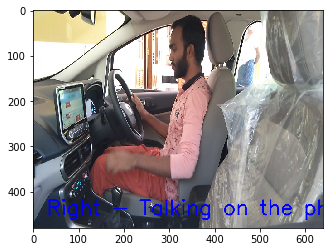

In [43]:
list = os.listdir("C:\\Users\\revan\\JUPYTERRRRRRRRRRRRRRRRRR\\Iris\Drowsiness\\prediction\\input\\framewise")
number_files = len(list)
for i in range(number_files):
    plot_test_classs(model_v1, manual_imgs, i)

In [44]:
video = cv2.VideoCapture('prediction/input/VID20200504144113-1.mp4');

    # Find OpenCV version
(major_ver, minor_ver, subminor_ver) = (cv2.__version__).split('.')

if int(major_ver)  < 3 :
    fps = video.get(cv2.cv.CV_CAP_PROP_FPS)
else :
    fps = video.get(cv2.CAP_PROP_FPS)
print(fps)

30.073765379968037


In [45]:
img_array = []
for filename in glob.glob('prediction/output/images/*.jpg'):
    img = cv2.imread(filename)
    height, width, layers = img.shape
    img_array.append(img)
size = (width,height)
 
out = cv2.VideoWriter('prediction/output/Video/outfvput.mp4',cv2.VideoWriter_fourcc(*'DIVX'), 1, size)
 
for i in range(len(img_array)):
    out.write(img_array[i])
out.release()